In [1]:
# Librerías
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols #Ordinary linear squares
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression

In [2]:
nba_data = pd.read_csv('https://cdncontribute.geeksforgeeks.org/wp-content/uploads/nba.csv')
nba_data.head()

,Name,Team,Number,Position,Age,Height,Weight,College,Salary
0,Avery Bradley,Boston Celtics,0.0,PG,25.0,6-2,180.0,Texas,7730337.0
1,Jae Crowder,Boston Celtics,99.0,SF,25.0,6-6,235.0,Marquette,6796117.0
2,John Holland,Boston Celtics,30.0,SG,27.0,6-5,205.0,Boston University,NaN
3,R.J. Hunter,Boston Celtics,28.0,SG,22.0,6-5,185.0,Georgia State,1148640.0
4,Jonas Jerebko,Boston Celtics,8.0,PF,29.0,6-10,231.0,NaN,5000000.0


In [7]:
# Tipo de Variables
nba_data.dtypes

Name         object
Team         object
Number      float64
Position     object
Age         float64
Height       object
Weight      float64
College      object
Salary      float64
dtype: object

In [15]:
# Estadisticos basicos
nba_data.describe()

,Number,Age,Weight,Salary
count,457.000000,457.000000,457.000000,4.460000e+02
mean,17.678337,26.938731,221.522976,4.842684e+06
std,15.966090,4.404016,26.368343,5.229238e+06
min,0.000000,19.000000,161.000000,3.088800e+04
25%,5.000000,24.000000,200.000000,1.044792e+06
50%,13.000000,26.000000,220.000000,2.839073e+06
75%,25.000000,30.000000,240.000000,6.500000e+06
max,99.000000,40.000000,307.000000,2.500000e+07


In [16]:
nba_data.shape

(458, 9)

In [19]:
# Valores faltantes
nba_data.isnull().sum() 
# Observamos que college es la variable con mas valores
# faltantes , 
# College : 85/458 -> 19%

Name         1
Team         1
Number       1
Position     1
Age          1
Height       1
Weight       1
College     85
Salary      12
dtype: int64


Eliminar las filas que tengan el salario nulo y la columna number, ya que esta no tiene ninguna relevancia

In [21]:
nba_data.dropna(subset = ['Salary','Number'],inplace = True)

In [25]:
nba_data.reset_index(drop= True,inplace = True)

In [28]:
nba_data.isnull().sum()

Name         0
Team         0
Number       0
Position     0
Age          0
Height       0
Weight       0
College     82
Salary       0
dtype: int64

In [58]:
# Forma mia
separete_cols= nba_data.Height.str.split("-",n = 1, expand = True)
separete_cols[0] = pd.to_numeric(separeta_cols[0])
separete_cols[1] = pd.to_numeric(separeta_cols[1])
cm_col = separete_cols[0] * 30.48  + separete_cols[1]*2.54
nba_data['Height'] = cm_col

In [62]:
nba_data.head()

,Name,Team,Number,Position,Age,Height,Weight,College,Salary
0,Avery Bradley,Boston Celtics,0.0,PG,25.0,187.96,180.0,Texas,7730337.0
1,Jae Crowder,Boston Celtics,99.0,SF,25.0,198.12,235.0,Marquette,6796117.0
2,R.J. Hunter,Boston Celtics,28.0,SG,22.0,195.58,185.0,Georgia State,1148640.0
3,Jonas Jerebko,Boston Celtics,8.0,PF,29.0,208.28,231.0,NaN,5000000.0
4,Amir Johnson,Boston Celtics,90.0,PF,29.0,205.74,240.0,NaN,12000000.0


In [ ]:
# Forma profe
def conversion(a):
    pie,pulg = a.split("-")
    cms = int(pie)*30.48 + int(pulg) * 2.54
    return cms
#Convirtiendo la columna Height 
# nba_data['Height']= nba_data['Height'].apply(conversion)

In [102]:
nba_data.dtypes

Name         object
Team         object
Number      float64
Position     object
Age         float64
Height      float64
Weight      float64
College      object
Salary      float64
dtype: object

Construir un histograma con las cinco universidades con mas jugadores en la NBA

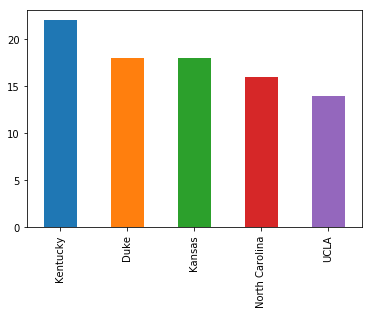

In [103]:
nba_data.College.value_counts().nlargest(5).plot(kind = 'bar')

Construir un boxplot en el que se muestre los salarios vs las posiciones de los jugadores. Esto permite entender si los salarios varian significativamente dependiendo de la posición.

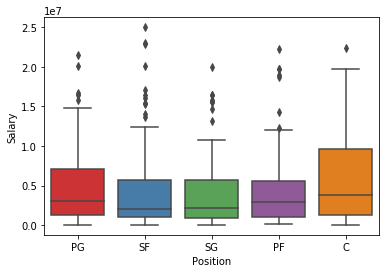

In [25]:
data_in["Position"] = data_in.index
sns.boxplot(x = "Position",y = "Salary",data = nba_data,palette = "Set1")

En general se observa que las medias de salarios varian segun la posición pero no es una desviación tan fuerte entre posición. Ademas observamos que las posiciones que más ganan con la C y PG , mientras que SF , SG Y PF se mantienen muy parecidas.

Obtener los cinco equipos que pagan los salarios mas altos (sumando toda la nómina de sus jugadores)

In [77]:
nba_data[['Team','Salary']].groupby('Team',as_index = False).agg('sum').nlargest(5,'Salary').reset_index(drop = True)

,Team,Salary
0,Cleveland Cavaliers,106988689.0
1,Los Angeles Clippers,94854640.0
2,Oklahoma City Thunder,93765298.0
3,Golden State Warriors,88868997.0
4,Chicago Bulls,86783378.0


In [33]:
# Otra forma:
nba_data.groupby(by = 'Team').Salary.sum().sort_values(ascending = False).nlargest(5)


Team
Cleveland Cavaliers      106988689.0
Los Angeles Clippers      94854640.0
Oklahoma City Thunder     93765298.0
Golden State Warriors     88868997.0
Chicago Bulls             86783378.0
Name: Salary, dtype: float64

Construir una tabla pivot que muestre el salario promedio de los jugadores por equipo y posición para para los cinco equipos que pagan mejores salarios. Construir una representación visual de la información anterior usando heatmap.

In [86]:
top_5_teams = list(nba_data[['Team','Salary']].groupby('Team').agg('sum').nlargest(5,'Salary').index)

In [87]:
# Selección top 5
nba_data_filt = nba_data[nba_data['Team'].isin(top_5_teams)]
nba_data_filt

,Name,Team,Number,Position,Age,Height,Weight,College,Salary
76,Leandro Barbosa,Golden State Warriors,19.0,SG,33.0,6-3,194.0,NaN,2500000.0
77,Harrison Barnes,Golden State Warriors,40.0,SF,24.0,6-8,225.0,North Carolina,3873398.0
78,Andrew Bogut,Golden State Warriors,12.0,C,31.0,7-0,260.0,Utah,13800000.0
79,Ian Clark,Golden State Warriors,21.0,SG,25.0,6-3,175.0,Belmont,947276.0
80,Stephen Curry,Golden State Warriors,30.0,PG,28.0,6-3,190.0,Davidson,11370786.0
81,Festus Ezeli,Golden State Warriors,31.0,C,26.0,6-11,265.0,Vanderbilt,2008748.0
82,Draymond Green,Golden State Warriors,23.0,PF,26.0,6-7,230.0,Michigan State,14260870.0
83,Andre Iguodala,Golden State Warriors,9.0,SF,32.0,6-6,215.0,Arizona,11710456.0
84,Shaun Livingston,Golden State Warriors,34.0,PG,30.0,6-7,192.0,NaN,5543725.0
85,Kevon Looney,Golden State Warriors,36.0,SF,20.0,6-9,220.0,UCLA,1131960.0


In [88]:
gp_nba_data = nba_data_filt[['Team','Position','Salary']].groupby(['Team','Position'],as_index = False).agg('mean').sort_values(by = "Salary",ascending = False).reset_index(drop = True)
gp_nba_data

,Team,Position,Salary
0,Cleveland Cavaliers,PF,1.394101e+07
1,Cleveland Cavaliers,SF,1.195889e+07
2,Chicago Bulls,PG,1.117153e+07
3,Chicago Bulls,C,1.042438e+07
4,Los Angeles Clippers,C,1.039480e+07
5,Oklahoma City Thunder,PG,9.382869e+06
6,Oklahoma City Thunder,SF,8.599621e+06
7,Los Angeles Clippers,PG,8.509072e+06
8,Golden State Warriors,PG,8.457256e+06
9,Golden State Warriors,PF,7.275312e+06


In [89]:
grouped_pivot = gp_nba_data.pivot(index = 'Position',columns = 'Team')


In [57]:
def heatmp(grouped_pivot):
    fig, ax = plt.subplots()
    im = ax.pcolor(grouped_pivot, cmap='jet')
    #labels
    row_labels = grouped_pivot.columns.levels[1]
    col_labels = grouped_pivot.index

    #move ticks to the center
    ax.set_xticks(np.arange(grouped_pivot.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(grouped_pivot.shape[0]) + 0.5, minor=False)
    #insert labels
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(col_labels, minor=False)
    #rotate the labels
    plt.xticks(rotation=90)
    fig.colorbar(im)
    plt.show()

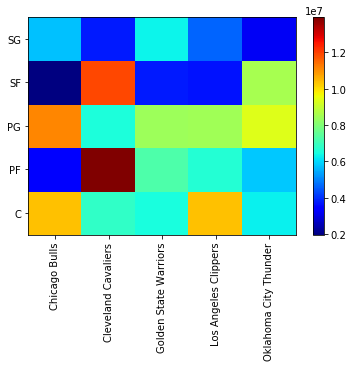

In [91]:
heatmp(grouped_pivot = grouped_pivot)

## Otra forma:

In [64]:
#Lista de los 5 equipos que pagan mayores salarios
topTeams=list(nba_data.groupby(by='Team').Salary.sum().sort_values(ascending=False).head().index)

#Seleción del dataset de los 5 equipos que pagan mayores salarios
dfTop=nba_data[nba_data['Team'].isin(topTeams)]

#Construcción de tabla pivot 
pivotNBA=dfTop.pivot_table('Salary', index='Position',columns='Team')
pivotNBA

Team,Chicago Bulls,Cleveland Cavaliers,Golden State Warriors,Los Angeles Clippers,Oklahoma City Thunder
Position,,,,,
C,10424380.00,6.828957e+06,6.541249e+06,1.039480e+07,6.303143e+06
PF,3361007.40,1.394101e+07,7.275312e+06,6.655482e+06,5.821013e+06
PG,11171532.00,6.551592e+06,8.457256e+06,8.509072e+06,9.382869e+06
SF,1958160.00,1.195889e+07,3.766367e+06,3.662924e+06,8.599621e+06
SG,5717549.25,3.761809e+06,6.316092e+06,4.639893e+06,3.207058e+06


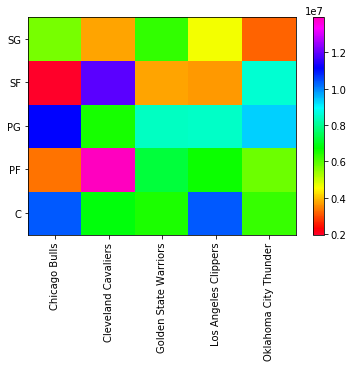

In [92]:
#Construcción de tabla pivot 
pivotNBA=dfTop.pivot_table('Salary', index='Position',columns='Team')

#Construcción heatmap
fig, ax = plt.subplots()
im = ax.pcolor(pivotNBA, cmap='gist_rainbow')

#label names
row_labels = pivotNBA.columns
col_labels = pivotNBA.index

#move ticks and labels to the center
ax.set_xticks(np.arange(pivotNBA.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(pivotNBA.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.show()

Utilizar el método scatter_matrix para visualizar si existe algún tipo de correlación entre las variables numéricas del dataset

In [38]:
from pandas.plotting import scatter_matrix
def cor_plot(df,pair_plot):
    numeric_cols =[]
    other_cols = []
    data_types = df.dtypes
    for i,v in data_types.items():
        if v == 'object':
            other_cols.append(i)
    print("Procesando información....")
    print("Extrayendo variables númericas")
    for i,v in data_types.items():
        if v == 'float64' or v == 'int64':
            numeric_cols.append(i)
    df_new = df[numeric_cols]
    print("Número de variables númericas encontradas: %s"%(len(numeric_cols)))
    print("Variables Númericas encontradas: \n")
    for var in numeric_cols:
        print(var)
    print("\n")
    print("Diagrama de Dispersión e Histogramas para las variables númericas\n")
    scatter_matrix(df_new, figsize=(12, 8))
    plt.show()
    corr_new = df_new.corr()
    print("Correlación de las variables númericas: \n")
    print("\n")
    print("Matriz de Correlación \n")
    print(corr_new)
    print("\n")
    print("Gráfico de Correlación")
    ax = sns.heatmap(
    corr_new, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right')
    if pair_plot:
        print("\n")
        cols_names = df.columns
        col_select = input("Elija una columna categorica para hacer el pair_plot: ")
        if col_select not in other_cols:
            print("No se selecciono una variable categorica")
        else:
            print("\n")
            print("Gráfico de Densidad y de Dispersión por Niveles de la Variabe Categorica: %s"%(col_select))
            sns.pairplot(df, hue = col_select, vars = numeric_cols)

Procesando información....
Extrayendo variables númericas
Número de variables númericas encontradas: 4
Variables Númericas encontradas: 

Number
Age
Weight
Salary


Diagrama de Dispersión e Histogramas para las variables númericas



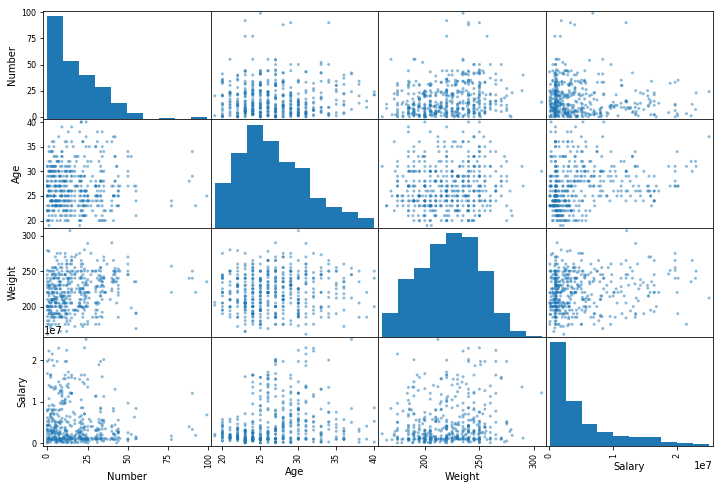

Correlación de las variables númericas: 



Matriz de Correlación 

          Number       Age    Weight    Salary
Number  1.000000  0.028724  0.206921 -0.112386
Age     0.028724  1.000000  0.087183  0.213459
Weight  0.206921  0.087183  1.000000  0.138321
Salary -0.112386  0.213459  0.138321  1.000000


Gráfico de Correlación


Elija una columna categorica para hacer el pair_plot: Position


Gráfico de Densidad y de Dispersión por Niveles de la Variabe Categorica: Position


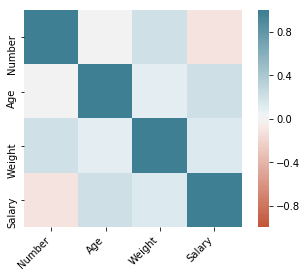

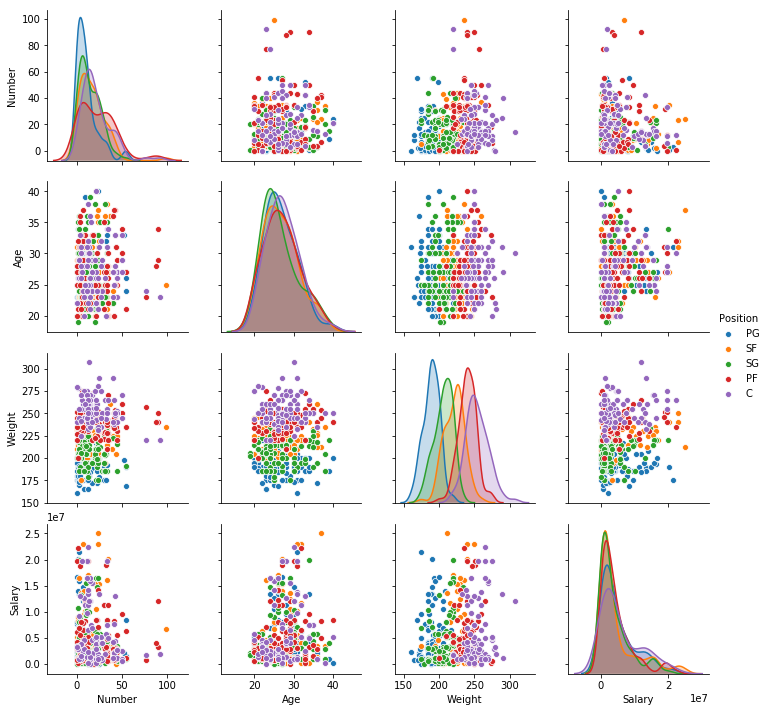

In [39]:
cor_plot(nba_data,pair_plot = True)

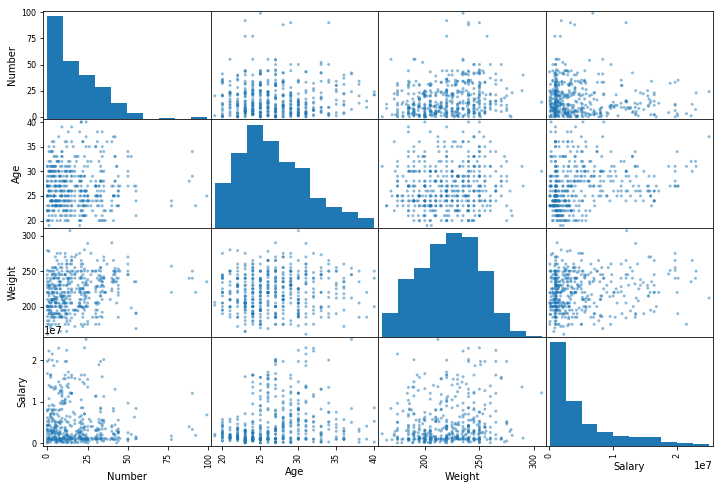

In [43]:
# Otra forma:

from pandas.plotting import scatter_matrix

scatter_matrix(nba_data, figsize=(12, 8))
plt.show()

In [33]:
nba_data.dtypes

Name         object
Team         object
Number      float64
Position     object
Age         float64
Height       object
Weight      float64
College      object
Salary      float64
dtype: object